# **Lahore Population and Environmental Trends (2016-2023)**

This notebook analyzes Lahore's population growth and its environmental impacts between 2016–2023.
It integrates population density (extracted from raster maps) with atmospheric and environmental data, and applies:

**Data Visualization** (trend plots, heatmaps, correlations),

**Regression Models** (Linear Regression, Random Forests),

**Unsupervised Clustering** (K-Means, DBSCAN),

**Time Series Forecasting** (LSTM Neural Network).

Key goals include understanding seasonal patterns, pollutant behavior, impact of population growth, and predicting future environmental conditions.

### Import Necessary Libraries

In [63]:
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from datetime import datetime
from rasterio.mask import mask
from shapely.geometry import box
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

### Define Geographic Area (Lahore Bounding Box) and Population Color Mapping

In [64]:
color_map = {
    (255, 255, 190): (1, 5),
    (255, 255, 115): (6, 25),
    (255, 255, 0): (26, 50),
    (255, 170, 0): (51, 100),
    (255, 102, 0): (101, 500),
    (255, 0, 0): (501, 2500),
    (204, 0, 0): (2501, 5000),
    (115, 0, 0): (5001, 185000)
}

min_lon, min_lat = 74.131025, 31.344181
max_lon, max_lat = 74.518443, 31.630759
bbox = box(min_lon, min_lat, max_lon, max_lat)

### Define Functions to Map Colors to Population and Calculate Density

In [65]:
def map_color_to_population(rgb):
    """Map RGB color to population density range."""
    return color_map.get(tuple(rgb), (0, 0))

def calculate_population_density(filename):
    # Bounding box for Lahore (approximate)
    geo = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

    with rasterio.open(filename) as src:
        geo = geo.to_crs(src.crs)  
        out_image, out_transform = mask(src, geo.geometry, crop=True)
        
        # Assume bands are [R, G, B]
        r = out_image[0]
        g = out_image[1]
        b = out_image[2]
        
        rgb_values = np.dstack((r, g, b))
        height, width, _ = rgb_values.shape

    # Map RGB to density
    population_density = np.zeros((height, width), dtype=float)
    
    for i in range(height):
        for j in range(width):
            rgb = rgb_values[i, j]
            min_pop, max_pop = map_color_to_population(rgb)
            population_density[i, j] = (min_pop + max_pop) / 2  # Average density

    # Ignore zero-density areas
    # non_zero_population = population_density[population_density > 0]
    # if len(non_zero_population) > 0:
    #     population = np.sum(non_zero_population)
    # else:
    #     population = 0

    # return population
    
    # Apply logarithmic transformation to reduce skewness
    log_population_density = np.log(population_density + 1)  # Add 1 to avoid log(0)

    # Calculate the average log-transformed population density
    log_avg_density = np.mean(log_population_density)

    # Inverse transformation to get back to the original scale
    avg_density = np.exp(log_avg_density) - 1

    return avg_density

### Calculate Population Densities (2016–2023) and Map to CSV

In [ ]:
# Calculate and store population densities from 2016 to 2023
years = list(range(2016, 2024))  
population_densities = []

for year in years:
    file_name = f"landscan_tifs/landscan-global-{year}-colorized.tif"
    density = calculate_population_density(file_name)
    population_densities.append(density)
    print(f"Year {year}: Average population density in Lahore = {density:.2f}")
    
# Create a dictionary to map year -> population
year_to_population = {year: pop for year, pop in zip(years, population_densities)}

# Read your CSV file
df = pd.read_csv("Lahore-PM-Aerosols-Dust-Monthly-Averaged-Data-2016-2024.csv", encoding="ISO-8859-1")

# Extract year from 'valid_time'
df['year'] = pd.to_datetime(df['valid_time']).dt.year

# Map population based on year
df['population'] = df['year'].map(year_to_population)

# Drop the helper 'year' column if you want
df.drop(columns=['year'], inplace=True)

# Save the updated CSV
df.to_csv("dataset.csv", index=False)

print("Population column added and CSV saved.")


Year 2016: Average population density in Lahore = 1200.83
Year 2017: Average population density in Lahore = 1325.92
Year 2018: Average population density in Lahore = 1353.23
Year 2019: Average population density in Lahore = 1471.36
Year 2020: Average population density in Lahore = 1499.03
Year 2021: Average population density in Lahore = 1524.15
Year 2022: Average population density in Lahore = 1555.10
Year 2023: Average population density in Lahore = 1602.29
Population column added and CSV saved.


### Plot Population Trend Over Years

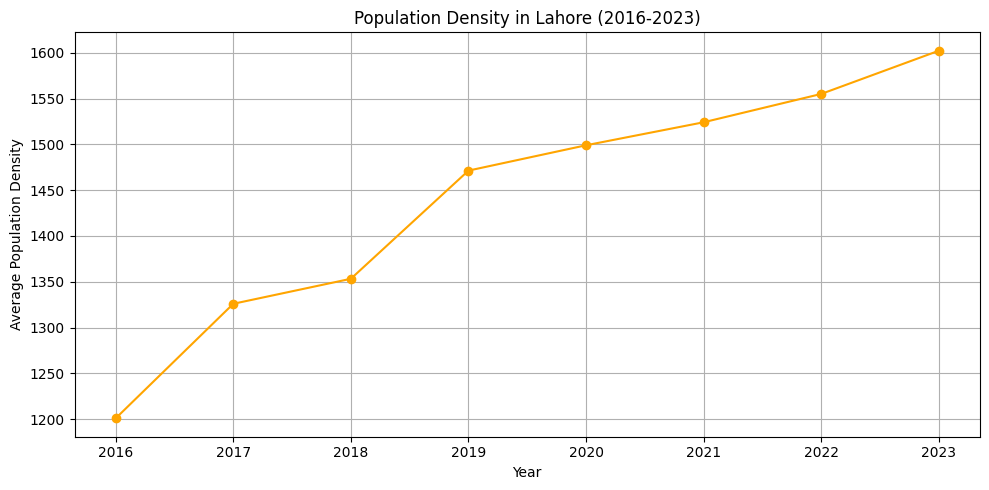

In [62]:
# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(years, population_densities, marker='o', linestyle='-', color='orange')
plt.title("Population Density in Lahore (2016-2023)")
plt.xlabel("Year")
plt.ylabel("Average Population Density")
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualize RGB Cropped Raster (Bounding Box of Lahore)

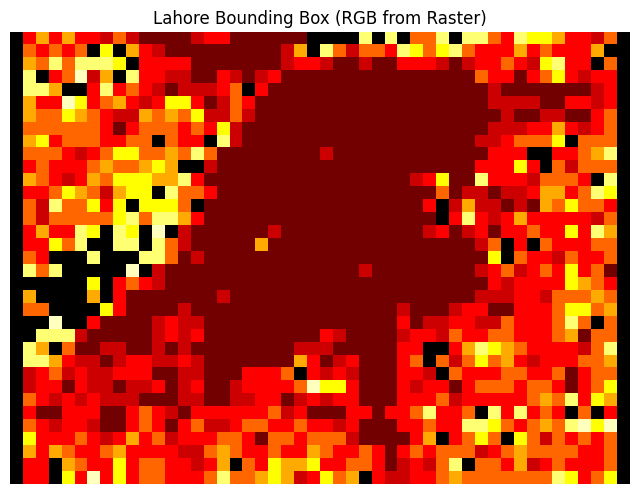

In [18]:
with rasterio.open(file_name) as src:
    geo = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')
    geo = geo.to_crs(src.crs)  # Match CRS with the raster
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    
    # Extract R, G, B bands
    r = out_image[0]
    g = out_image[1]
    b = out_image[2]
    
    # Stack into RGB image
    rgb = np.dstack((r, g, b)).astype(np.uint8)

# Plot the cropped RGB image
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Lahore Bounding Box (RGB from Raster)")
plt.axis('off')
plt.show()


### Loading and Exploring the Dataset

In [ ]:
data = pd.read_csv('dataset.csv', parse_dates=['valid_time'], dayfirst=True)
data['year'] = data['valid_time'].dt.year
data['month'] = data['valid_time'].dt.month

data.head()

,valid_time,latitude,longitude,Black carbon aerosol optical depth at 550 nm,Dust aerosol optical depth at 550 nm,Leaf area index low vegetation,Organic matter aerosol optical depth at 550 nm,Particulate matter d < 2.5 µm (PM2.5),Particulate matter d < 10 µm (PM10),Soil temperature level 1,Surface pressure,Total aerosol optical depth at 550 nm,population,year,month
0,2016-01-01 12:00:00,31.469,74.284,0.029164,0.016248,1.205675,0.534856,1.920000e-07,2.710000e-07,0.224423,99247.69,0.808605,1200.826152,2016,1
1,2016-02-01 12:00:00,31.469,74.284,0.025181,0.026584,1.644811,0.355844,1.150000e-07,1.620000e-07,0.142912,99131.75,0.553915,1200.826152,2016,2
2,2016-03-01 12:00:00,31.469,74.284,0.020344,0.068492,1.587820,0.329578,8.720000e-08,1.230000e-07,0.166913,98792.31,0.588048,1200.826152,2016,3
3,2016-04-01 12:00:00,31.469,74.284,0.017440,0.079398,1.089281,0.219141,4.670000e-08,6.570000e-08,0.105059,98195.06,0.422888,1200.826152,2016,4
4,2016-05-01 12:00:00,31.469,74.284,0.027403,0.203788,0.871900,0.318505,6.430000e-08,9.210000e-08,0.177101,97641.00,0.728252,1200.826152,2016,5


### Droping Unnecessary Columns

In [ ]:
data.drop(['valid_time', 'latitude', 'longitude'], axis=1, inplace=True)
data.head()

,Black carbon aerosol optical depth at 550 nm,Dust aerosol optical depth at 550 nm,Leaf area index low vegetation,Organic matter aerosol optical depth at 550 nm,Particulate matter d < 2.5 µm (PM2.5),Particulate matter d < 10 µm (PM10),Soil temperature level 1,Surface pressure,Total aerosol optical depth at 550 nm,population,year,month
0,0.029164,0.016248,1.205675,0.534856,1.920000e-07,2.710000e-07,0.224423,99247.69,0.808605,1200.826152,2016,1
1,0.025181,0.026584,1.644811,0.355844,1.150000e-07,1.620000e-07,0.142912,99131.75,0.553915,1200.826152,2016,2
2,0.020344,0.068492,1.587820,0.329578,8.720000e-08,1.230000e-07,0.166913,98792.31,0.588048,1200.826152,2016,3
3,0.017440,0.079398,1.089281,0.219141,4.670000e-08,6.570000e-08,0.105059,98195.06,0.422888,1200.826152,2016,4
4,0.027403,0.203788,0.871900,0.318505,6.430000e-08,9.210000e-08,0.177101,97641.00,0.728252,1200.826152,2016,5


## **Exploratory Data Analysis (EDA)**

### Monthly Trends for Each Feature

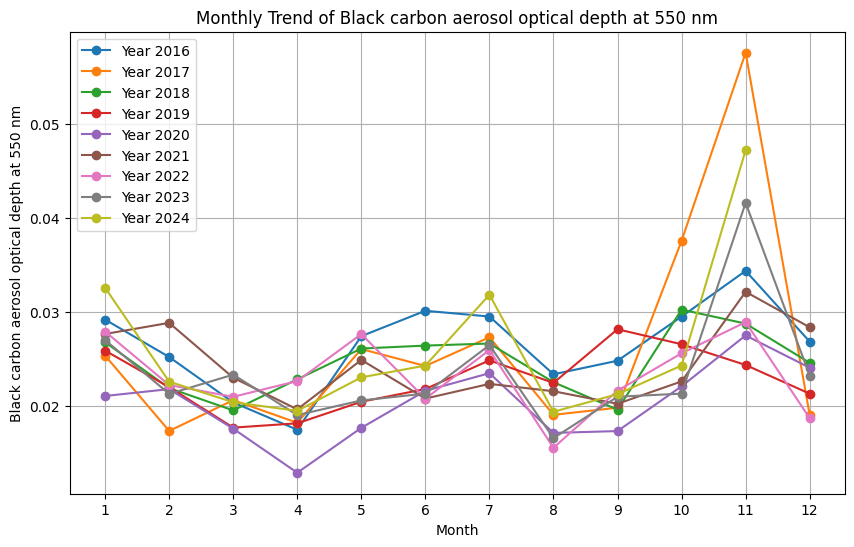

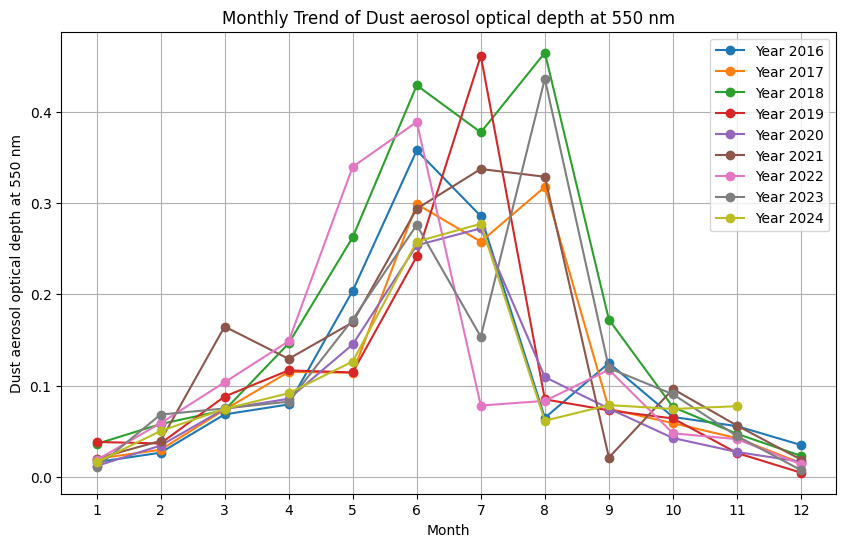

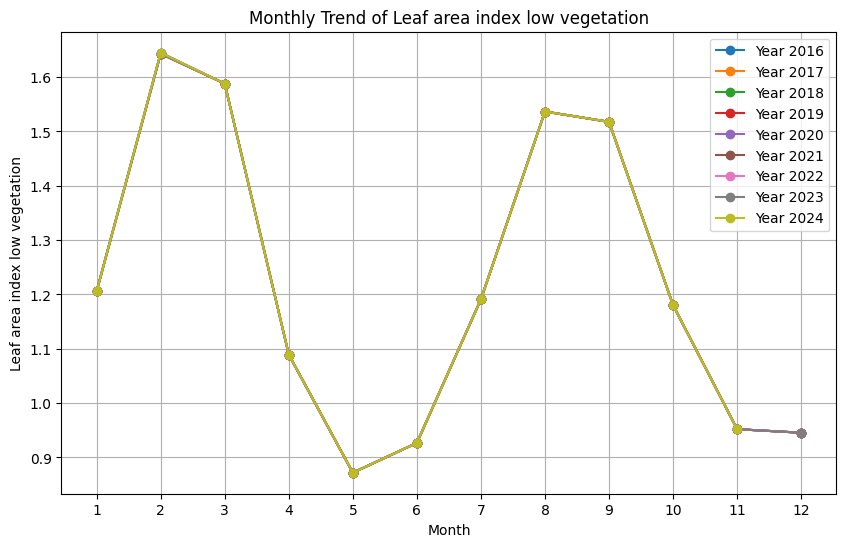

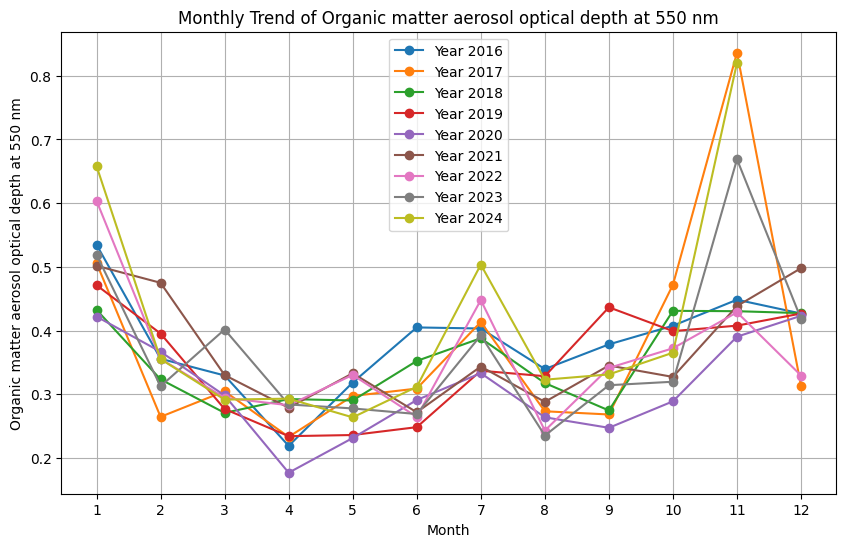

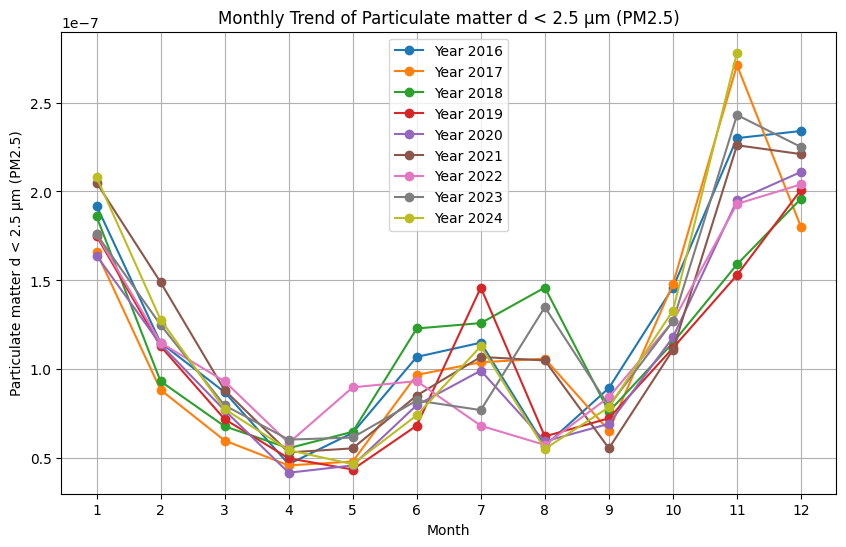

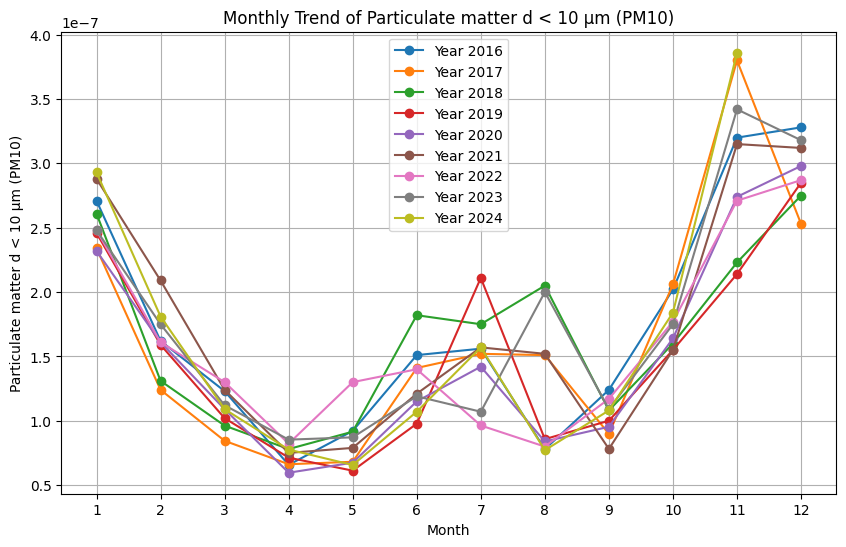

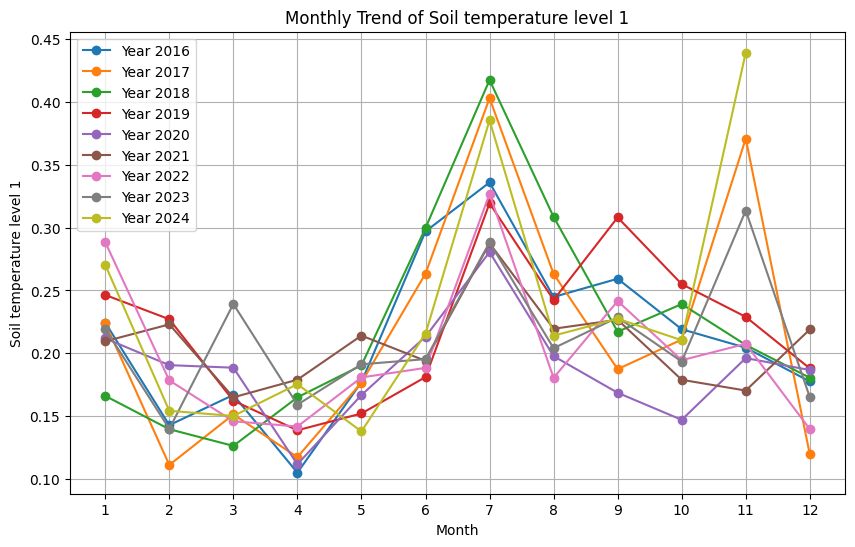

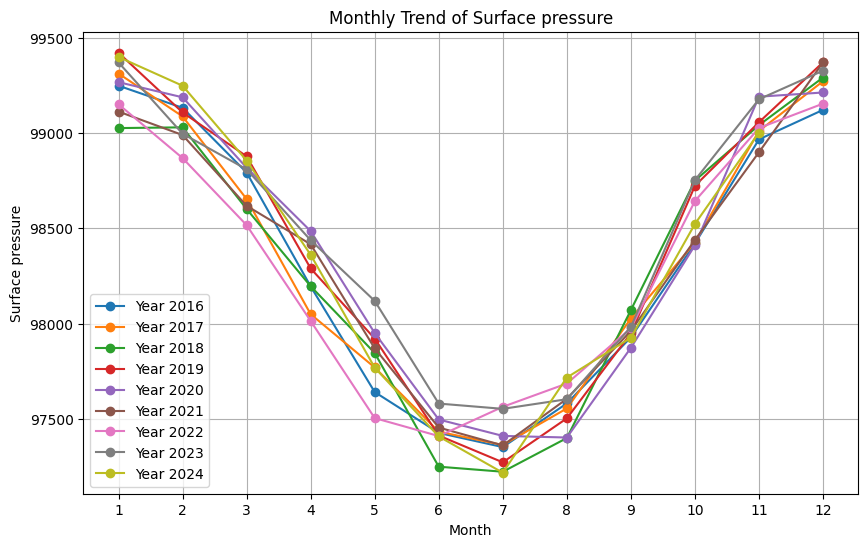

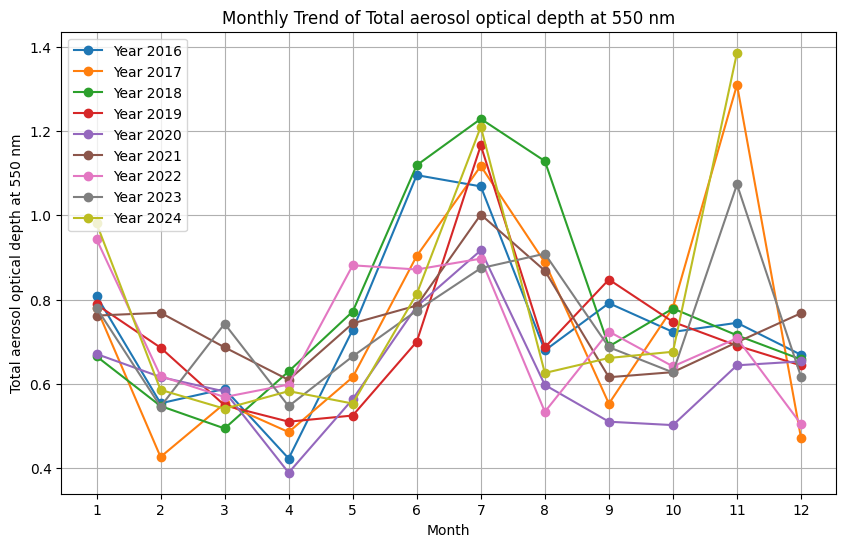

In [ ]:
features_to_plot = data.columns.drop(['year', 'month',"population"])

# For each feature
for feature in features_to_plot:
    plt.figure(figsize=(10,6))
    
    # For each year
    for year in data['year'].unique():
        subset = data[data['year'] == year]
        monthly_mean = subset.groupby('month')[feature].mean()
        plt.plot(monthly_mean.index, monthly_mean.values, marker='o', label=f'Year {year}')
    
    plt.title(f'Monthly Trend of {feature}')
    plt.xlabel('Month')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1,13))
    plt.show()


### Heatmap for Each Feature

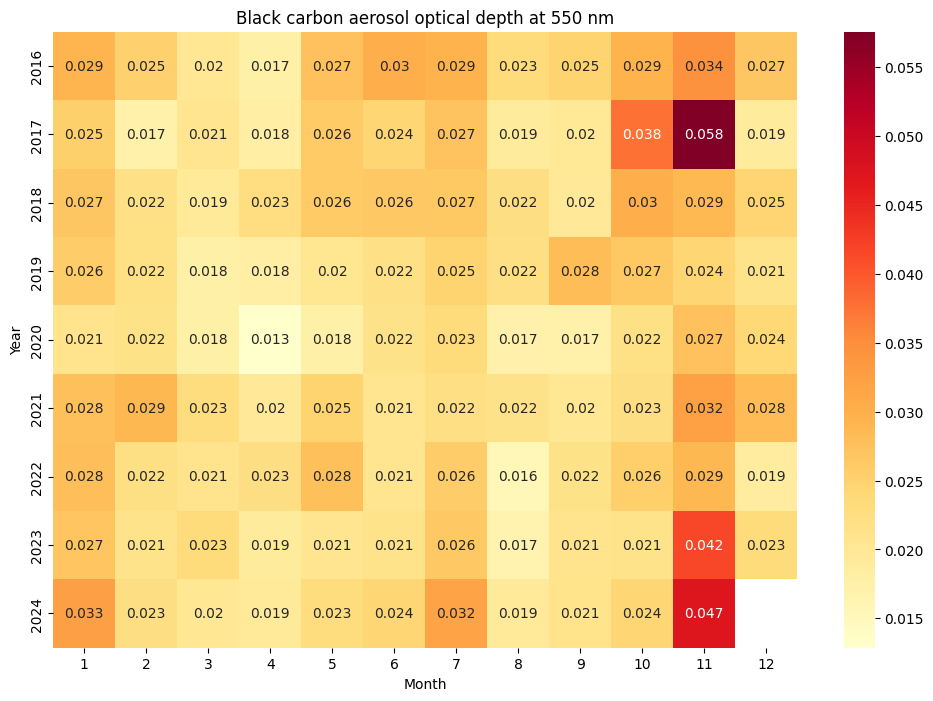

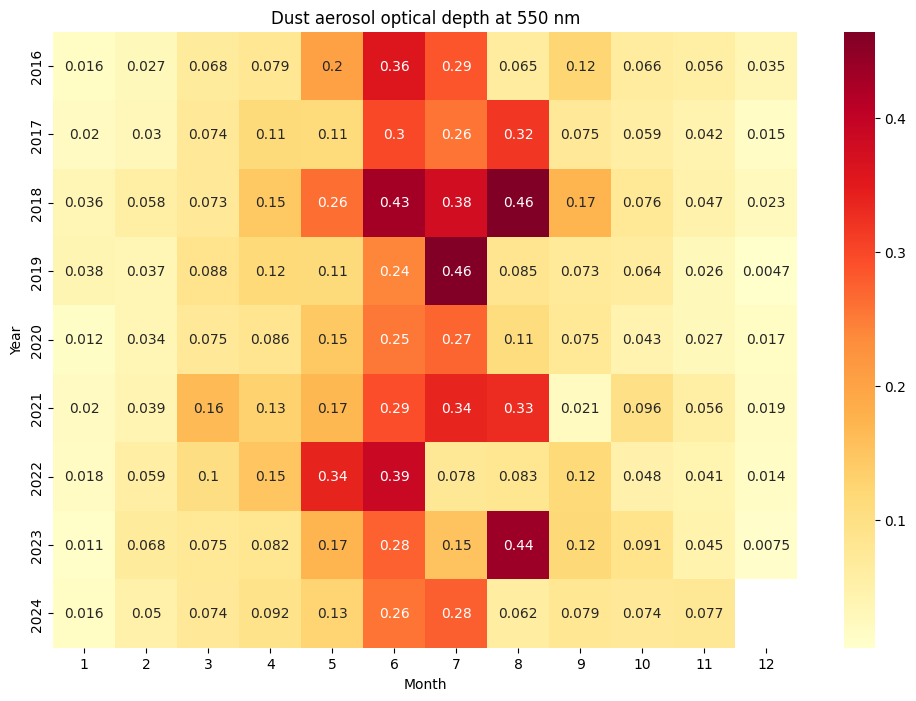

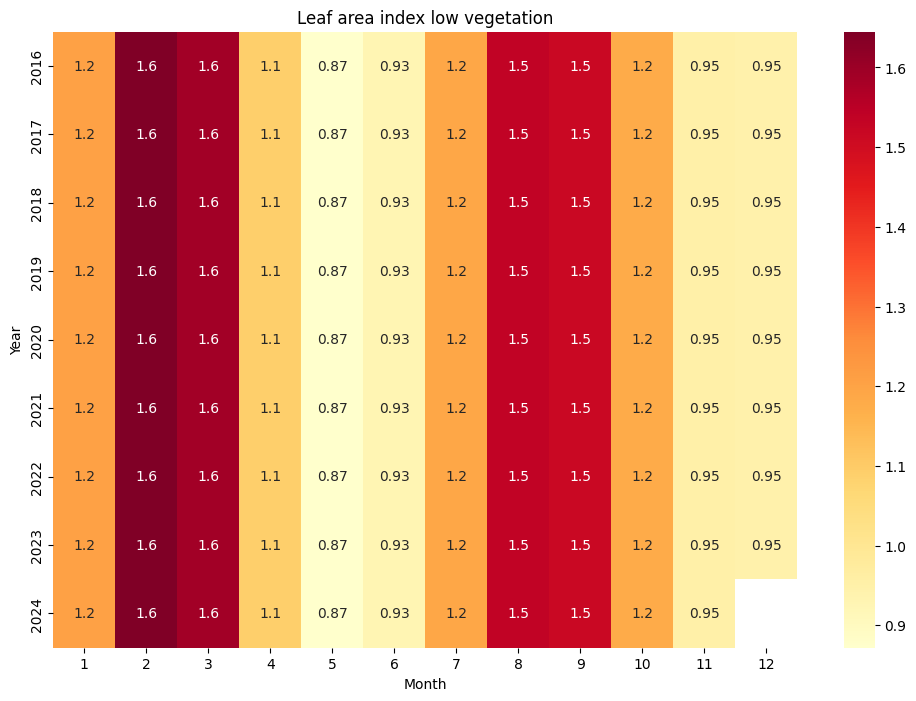

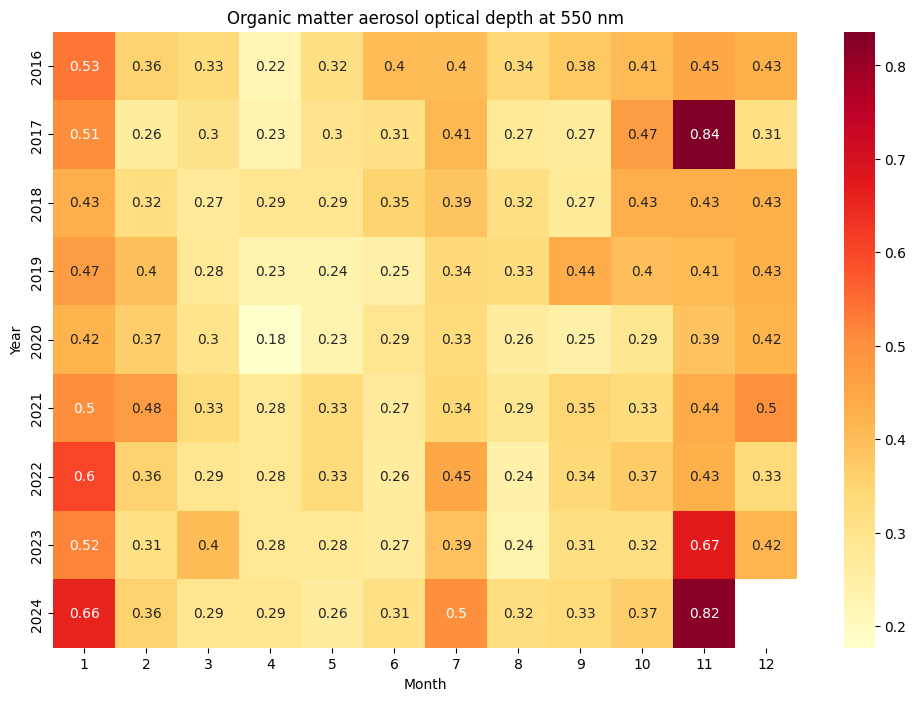

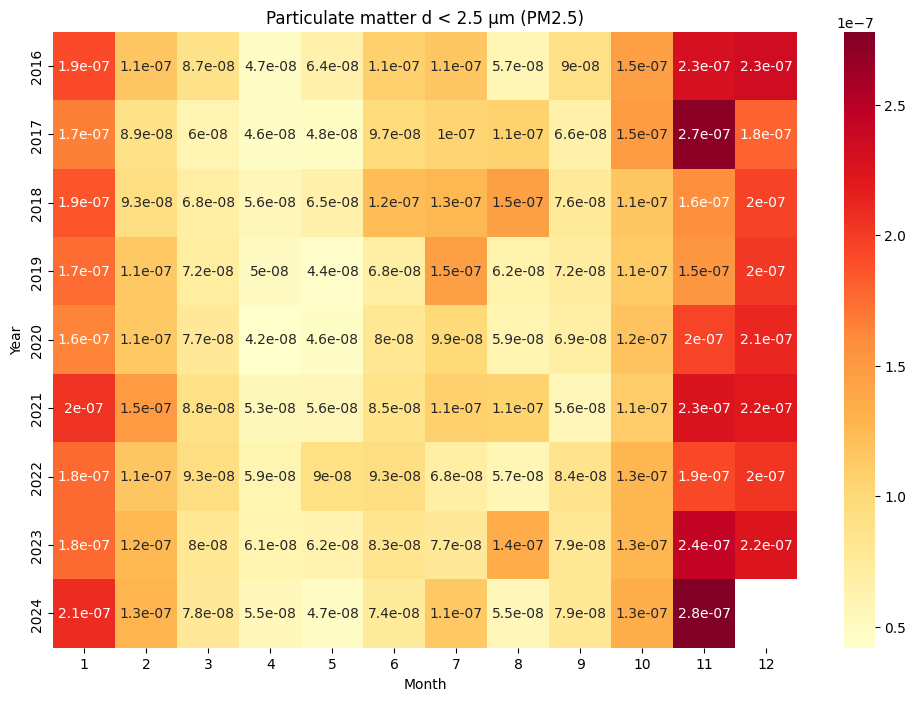

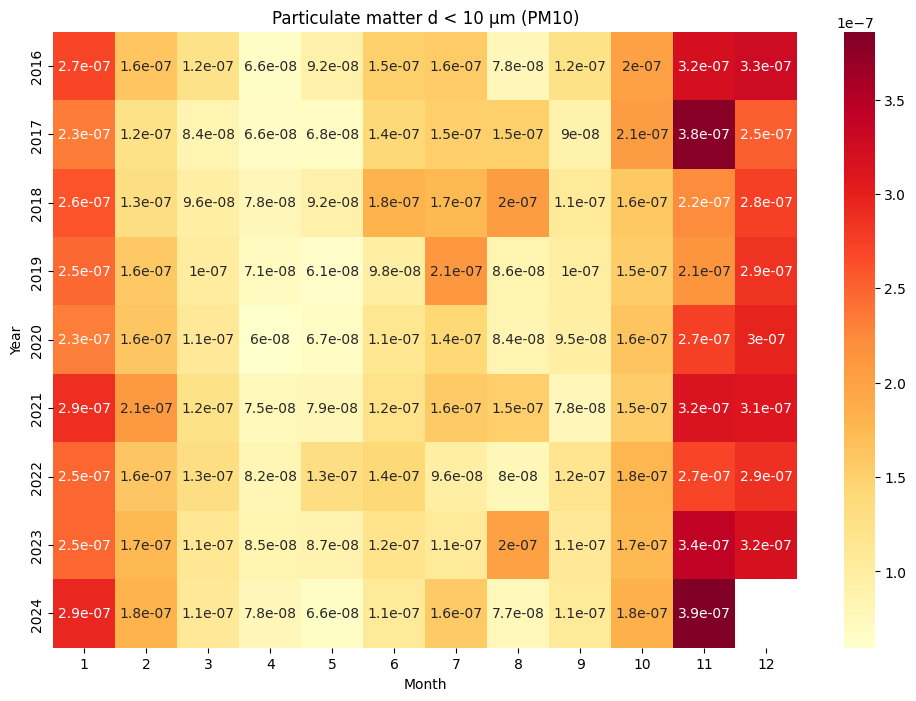

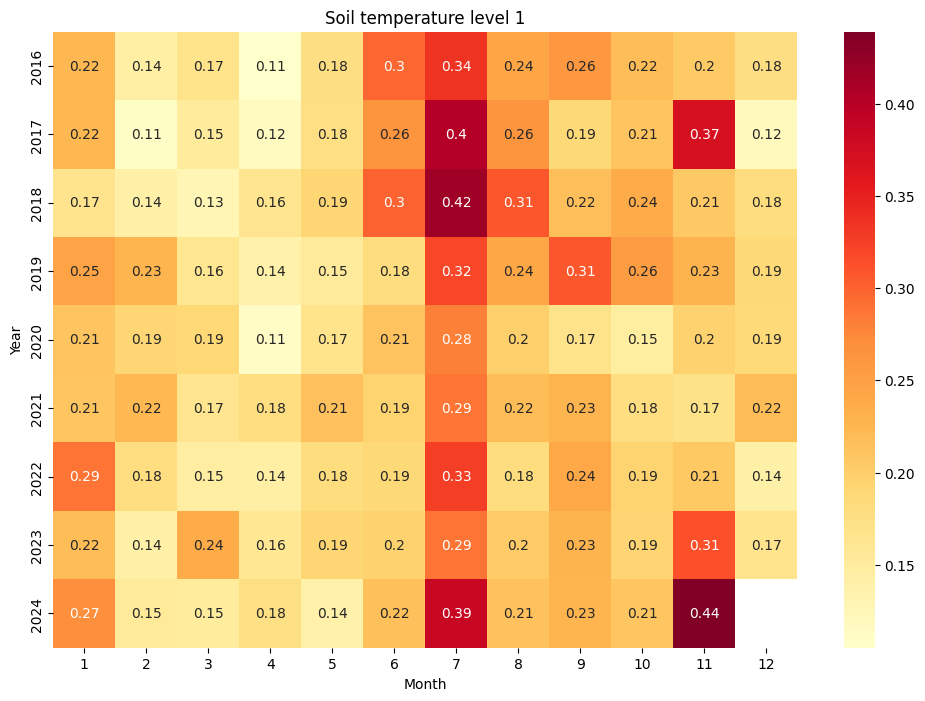

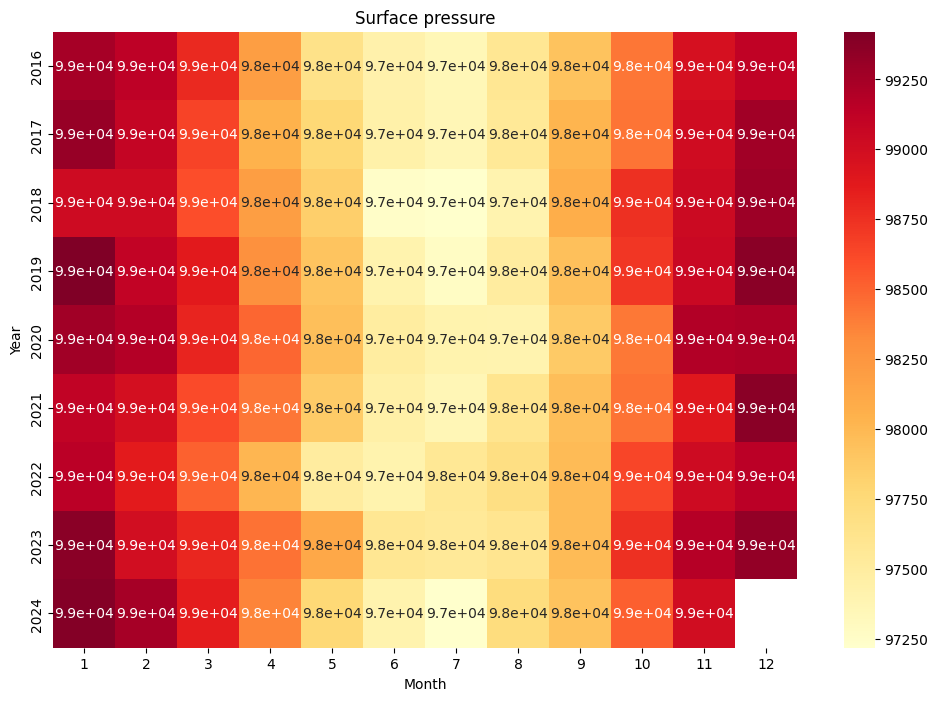

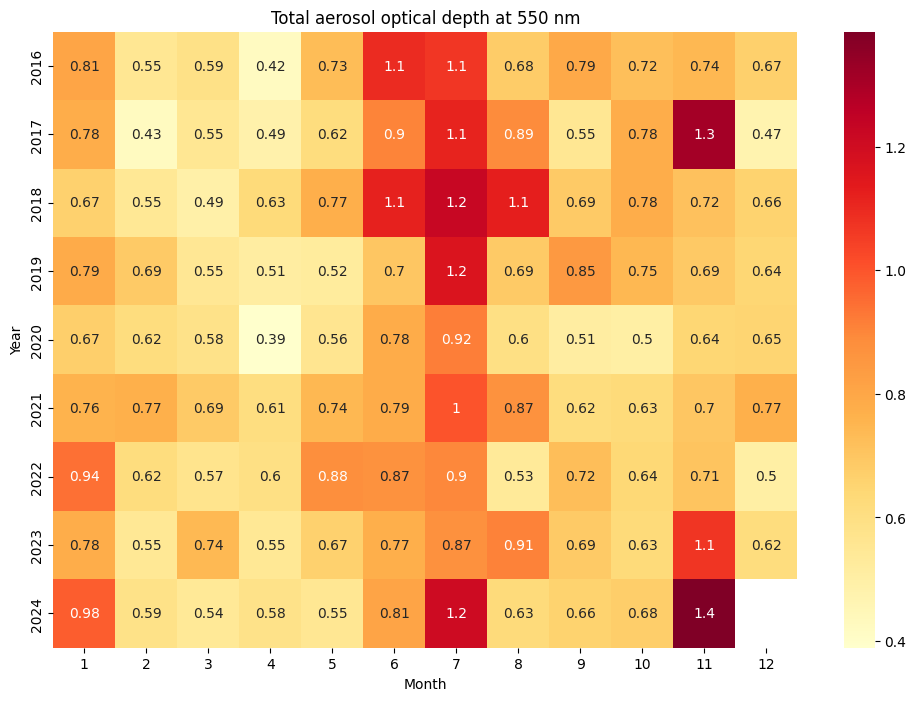

In [ ]:
features_to_plot = data.columns.drop(['year', 'month',"population"])

for factor in features_to_plot:
	pivot_table = data.pivot_table(values=factor, index='year', columns='month')

	plt.figure(figsize=(12,8))
	sns.heatmap(pivot_table, annot=True, cmap='YlOrRd')
	plt.title(factor)
	plt.xlabel('Month')
	plt.ylabel('Year')
	plt.show()

### Simple Linear Regression Models for Each Target

In [ ]:
features = ['population', 'month']  # Predictors
target_columns = [
    'Black carbon aerosol optical depth at 550 nm',
    'Dust aerosol optical depth at 550 nm',
    'Leaf area index low vegetation',
    'Organic matter aerosol optical depth at 550 nm',
    'Particulate matter d < 2.5 µm (PM2.5)',
    'Particulate matter d < 10 µm (PM10)',
    'Soil temperature level 1',
    'Surface pressure',
    'Total aerosol optical depth at 550 nm'
]  # Target features

# Initialize the model
model = LinearRegression()

# Loop through each target feature and calculate R² for each one
r2_scores = {}

for target in target_columns:
    # Prepare the data
    X = data[features]  # Features (population and month)
    y = data[target]  # Target variable

    # Split the data into training and testing sets (2016-2021 for training, 2022-2023 for testing)
    train_data = data[data['year'] <= 2021]
    test_data = data[data['year'] >= 2022]

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate R² (R-squared) for the test set
    r2 = r2_score(y_test, y_pred)

    # Store the R² value for the current feature
    r2_scores[target] = r2


for target, r2 in r2_scores.items():
    print(f"R² for {target}: {r2:.4f}")


R² for Black carbon aerosol optical depth at 550 nm: -0.1903
R² for Dust aerosol optical depth at 550 nm: 0.0002
R² for Leaf area index low vegetation: 0.1131
R² for Organic matter aerosol optical depth at 550 nm: -0.1076
R² for Particulate matter d < 2.5 Ã¯Â¿Â½m (PM2.5): 0.1167
R² for Particulate matter d < 10 Ã¯Â¿Â½m (PM10): 0.1170
R² for Soil temperature level 1: -0.0378
R² for Surface pressure: -0.0037
R² for Total aerosol optical depth at 550 nm: -0.1253


### Correlation of Features

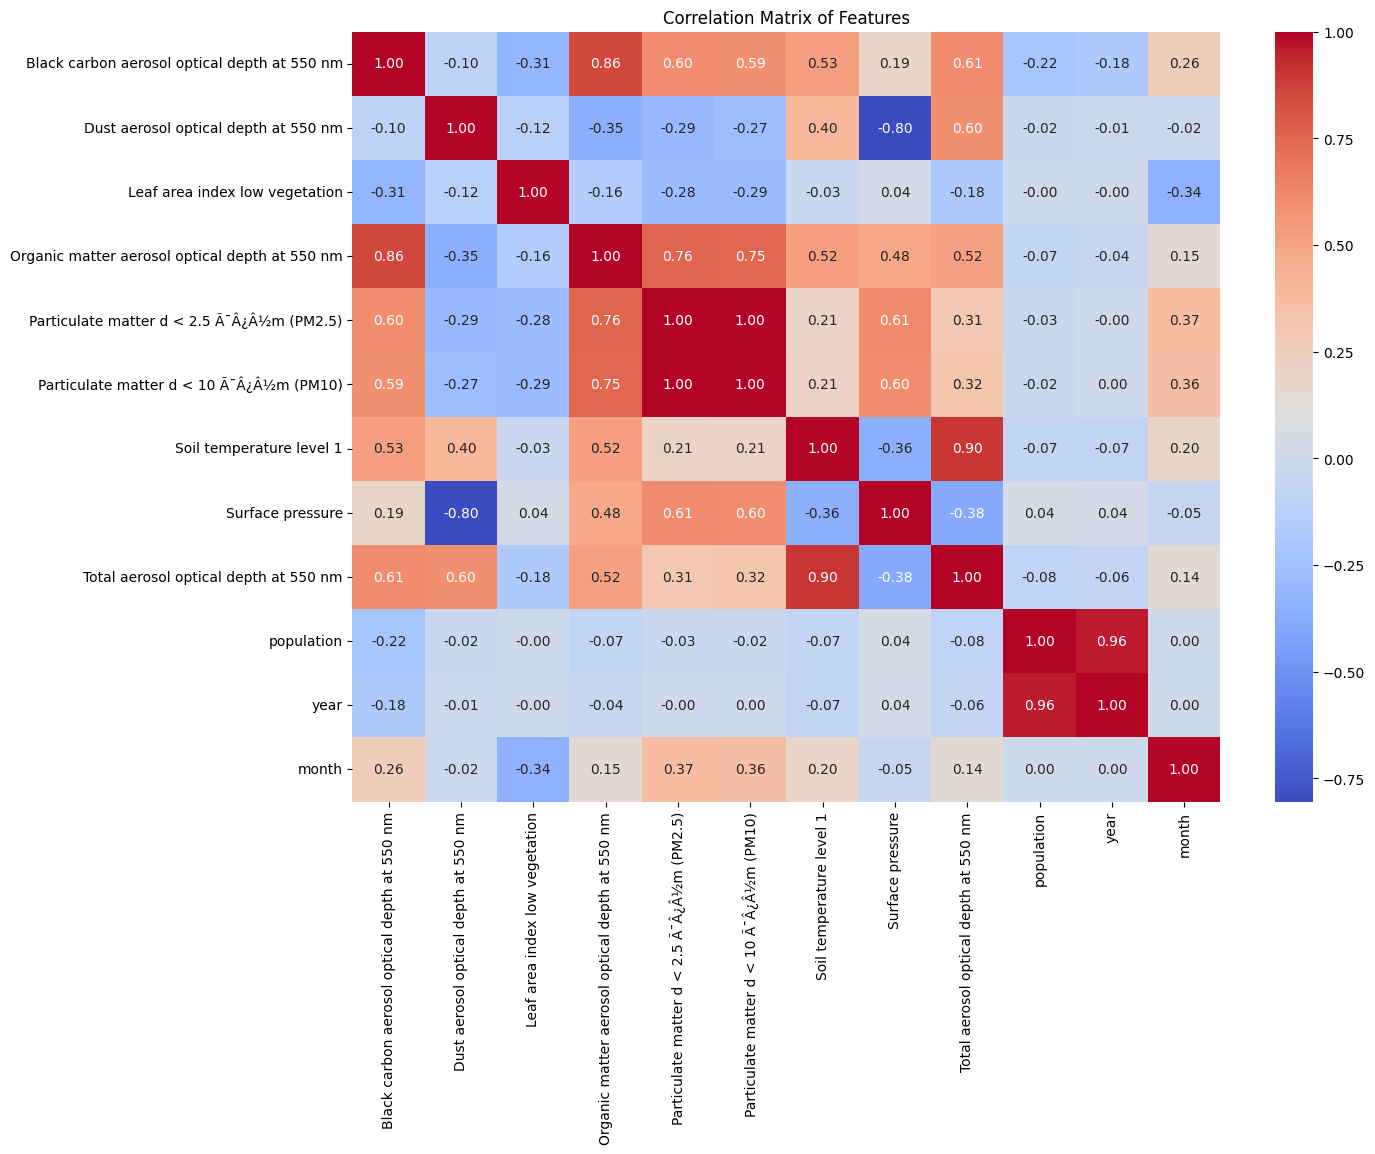

In [ ]:
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

### Analysis:


First, remember:  
**Correlation (r)** tells **how strongly** two variables are **related**:
- **+1** ➔ Perfect positive relation (move together).
- **-1** ➔ Perfect negative relation (move opposite).
- **0** ➔ No relation.

---

##  Strong Relationships Found:

## Very Strong Positive Correlations:

| Feature 1 | Feature 2 | Correlation | Meaning |
|:---|:---|:---|:---|
| **Particulate matter d < 2.5 µm (PM2.5)** | **PM10** | **0.999** | These two pollutants behave almost identically. |
| **Population** | **Year** | **0.963** | Population is growing every year almost linearly. |
| **Soil temperature level 1** | **Total aerosol optical depth at 550 nm** | **0.904** | Soil temperature rises with total aerosol presence. |
| **Organic matter aerosol optical depth** | **Black carbon aerosol optical depth** | **0.857** | These two aerosol components are closely related. |

---

##  Moderate Correlations:

| Feature 1 | Feature 2 | Correlation | Meaning |
|:---|:---|:---|:---|
| **Black carbon** | **PM2.5** | **0.599** | Moderate relation; higher black carbon increases PM2.5 pollution. |
| **Black carbon** | **Total aerosol optical depth** | **0.606** | Black carbon significantly impacts total aerosols. |
| **Surface Pressure** | **PM2.5 / PM10** | **0.613**, **0.604** | Higher pressure is somewhat related to more particulate matter. |

---

##  Negative Correlations:

| Feature 1 | Feature 2 | Correlation | Meaning |
|:---|:---|:---|:---|
| **Dust aerosol** | **Surface pressure** | **-0.804** | Dust storms may cause low-pressure systems. |
| **Leaf Area Index** | **Month** | **-0.336** | Vegetation decreases as months progress (seasonality). |
| **Black carbon** | **Leaf Area Index** | **-0.313** | High pollution negatively impacts vegetation. |
| **Dust aerosol** | **Organic matter aerosol** | **-0.349** | Different sources or behavior patterns. |

---

##  Special Observations:

- **Population** has almost **no direct correlation** with pollution indicators (only linked to year).
- **Month** moderately influences **PM2.5** and **PM10** (~0.36 correlation).
  - ➔ Indicates **seasonal pollution variations**.
- **Surface Pressure** tends to **decrease** with **dust aerosol increases**.

---

#  In short:

- **PM2.5** and **PM10** are almost identical ➔ *can be merged or used interchangeably*.
- **Black Carbon** and **Organic Aerosol** are tightly linked.
- **Seasonal patterns** exist, particularly impacting vegetation and pollution.
- **Dust events** (Dust aerosols) show strong weather dependency (Surface Pressure).

---

# Final Thoughts:

You can use this correlation study to:
- **Remove redundant features** (e.g., PM2.5 vs PM10).
- **Focus on key variables** for predicting air quality.
- **Handle seasonal variation** carefully during modeling (months matter).
- **Be cautious** of environmental dependencies like **dust** and **pressure**.



### Train a Random Forest Model for PM2.5

In [ ]:
target = 'Particulate matter d < 2.5 µm (PM2.5)'
X = data.drop(columns=[target])
y = data[target]

# Split into train and test (2016-2021 for train, 2022-2023 for test)
X_train = X[data['year'] <= 2021]
y_train = y[data['year'] <= 2021]
X_test = X[data['year'] >= 2022]
y_test = y[data['year'] >= 2022]

# Train Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                                           Feature  Importance
4         Particulate matter d < 10 Ã¯Â¿Â½m (PM10)    0.989334
5                         Soil temperature level 1    0.004107
0     Black carbon aerosol optical depth at 550 nm    0.001944
7            Total aerosol optical depth at 550 nm    0.001380
3   Organic matter aerosol optical depth at 550 nm    0.001229
1             Dust aerosol optical depth at 550 nm    0.001096
6                                 Surface pressure    0.000447
8                                       population    0.000310
10                                           month    0.000069
9                                             year    0.000047
2                   Leaf area index low vegetation    0.000036


### Correlation with Target (PM2.5)

In [ ]:

correlation_with_target = correlation_matrix['Particulate matter d < 2.5 µm (PM2.5)'].sort_values(ascending=False)
print(correlation_with_target)

Particulate matter d < 2.5 Ã¯Â¿Â½m (PM2.5)        1.000000
Particulate matter d < 10 Ã¯Â¿Â½m (PM10)          0.999484
Organic matter aerosol optical depth at 550 nm    0.757294
Surface pressure                                  0.613683
Black carbon aerosol optical depth at 550 nm      0.599040
month                                             0.368904
Total aerosol optical depth at 550 nm             0.309164
Soil temperature level 1                          0.207919
year                                             -0.000637
population                                       -0.027514
Leaf area index low vegetation                   -0.280279
Dust aerosol optical depth at 550 nm             -0.293022
Name: Particulate matter d < 2.5 Ã¯Â¿Â½m (PM2.5), dtype: float64


### Random Forest + Cross-Validation

In [ ]:
# Select relevant features based on correlation with Surface Pressure
features_sp = [
     
    'Particulate matter d < 10 µm (PM10)', 
    'Organic matter aerosol optical depth at 550 nm',
    'Black carbon aerosol optical depth at 550 nm', 
    "month",
    "Soil temperature level 1",
    "population",
]

target_sp = 'Particulate matter d < 2.5 µm (PM2.5)'

# Prepare the data
X_sp = data[features_sp]
y_sp = data[target_sp]

# Split into training and testing sets
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_sp, y_sp, test_size=0.2, random_state=42)

# Scale the features (important for some models)
scaler_sp = StandardScaler()
X_train_scaled_sp = scaler_sp.fit_transform(X_train_sp)
X_test_scaled_sp = scaler_sp.transform(X_test_sp)

# Train the Random Forest model
model_sp = RandomForestRegressor(random_state=42)
model_sp.fit(X_train_scaled_sp, y_train_sp)

# Make predictions
y_pred_sp = model_sp.predict(X_test_scaled_sp)

# Evaluate the model
r2_sp = r2_score(y_test_sp, y_pred_sp)
mse_sp = mean_squared_error(y_test_sp, y_pred_sp)
mae_sp = mean_absolute_error(y_test_sp, y_pred_sp)

# Print results
print(f"R²: {r2_sp}")
print(f"MSE: {mse_sp}")
print(f"MAE: {mae_sp}")

# Feature Importance
importances_sp = model_sp.feature_importances_
for feature, importance in zip(features_sp, importances_sp):
    print(f"Feature: {feature}, Importance: {importance}")

R²: 0.9155983218682224
MSE: 3.1527676943793937e-16
MAE: 1.2188429170590506e-08
Feature: Particulate matter d < 10 Ã¯Â¿Â½m (PM10), Importance: 0.9985239158640061
Feature: Organic matter aerosol optical depth at 550 nm, Importance: 0.0
Feature: Black carbon aerosol optical depth at 550 nm, Importance: 0.0
Feature: month, Importance: 0.0005530930939003658
Feature: Soil temperature level 1, Importance: 0.0009229910420935077
Feature: population, Importance: 0.0


In [ ]:
print(data['Particulate matter d < 2.5 µm (PM2.5)'].describe())

count    9.600000e+01
mean     1.157438e-07
std      5.666800e-08
min      4.190000e-08
25%      6.837500e-08
50%      1.045000e-07
75%      1.500000e-07
max      2.710000e-07
Name: Particulate matter d < 2.5 Ã¯Â¿Â½m (PM2.5), dtype: float64


### Model Performance Evaluation

In [ ]:
# Select relevant features based on correlation with Surface Pressure
features_sp = [
    'Particulate matter d < 10 µm (PM10)', 
    'Organic matter aerosol optical depth at 550 nm',
    'Black carbon aerosol optical depth at 550 nm', 
    "month",
    "Soil temperature level 1",
    "population",
]

target_sp = 'Particulate matter d < 2.5 µm (PM2.5)'

# Prepare the data
X_sp = data[features_sp]
y_sp = data[target_sp]

# Scale the features
scaler_sp = StandardScaler()
X_scaled_sp = scaler_sp.fit_transform(X_sp)

# Initialize the RandomForestRegressor
model_sp = RandomForestRegressor(random_state=42)

# Perform cross-validation
# We will use 5-fold cross-validation here
cv_results = cross_validate(
    model_sp, X_scaled_sp, y_sp, cv=5, 
    scoring=None, return_train_score=False
)

# Cross-validation results (R², MSE, MAE for each fold)
print("Cross-validation results:")
for fold, score in enumerate(cv_results['test_score']):
    print(f"Fold {fold+1}: R² = {score:.4f}")

# You can also calculate MSE and MAE for each fold
# Define custom scorers for MSE and MAE
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)

# MSE and MAE cross-validation
cv_mse = cross_val_score(model_sp, X_scaled_sp, y_sp, cv=5, scoring=mse_scorer)
cv_mae = cross_val_score(model_sp, X_scaled_sp, y_sp, cv=5, scoring=mae_scorer)

# Print MSE and MAE for each fold
print("\nMSE (for each fold):")
print(cv_mse)

print("\nMAE (for each fold):")
print(cv_mae)

# Compute the average R², MSE, and MAE
print("\nAverage Cross-Validation Results:")
print(f"Average R²: {np.mean(cv_results['test_score']):.4f}")
print(f"Average MSE: {np.mean(cv_mse):.4f}")
print(f"Average MAE: {np.mean(cv_mae):.4f}")


Cross-validation results:
Fold 1: R² = 0.9680
Fold 2: R² = 0.9334
Fold 3: R² = 0.9481
Fold 4: R² = 0.9866
Fold 5: R² = 0.9449

MSE (for each fold):
[9.91258133e-17 2.07404567e-16 1.03030162e-16 4.69602911e-17
 1.85708799e-16]

MAE (for each fold):
[8.46494015e-09 1.04872508e-08 7.78732783e-09 6.02809229e-09
 1.11500697e-08]

Average Cross-Validation Results:
Average R²: 0.9562
Average MSE: 0.0000
Average MAE: 0.0000


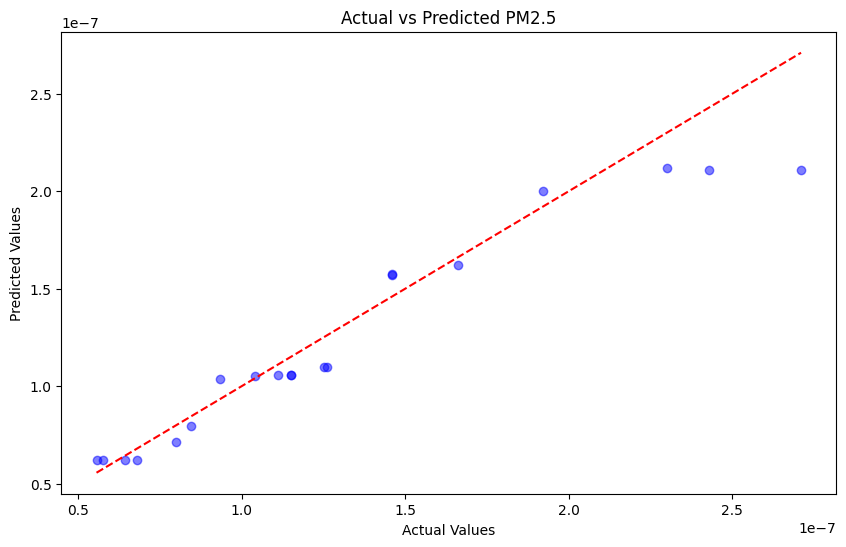

In [ ]:
# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test_sp, y_pred_sp, color='blue', alpha=0.5)

# Adding labels and title
plt.plot([min(y_test_sp), max(y_test_sp)], [min(y_test_sp), max(y_test_sp)], color='red', linestyle='--')  # line for perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted PM2.5")

# Show the plot
plt.show()


In [ ]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual PM2.5': y_test_sp,
    'Predicted PM2.5': y_pred_sp
})

# Print the first few rows of the comparison
print(comparison_df.head())


    Actual PM2.5  Predicted PM2.5
80  8.440000e-08     7.960414e-08
77  9.340000e-08     1.036315e-07
73  1.150000e-07     1.058748e-07
94  2.430000e-07     2.108361e-07
33  1.150000e-07     1.058748e-07


## **Clustering Analysis**

In [24]:
# Group by month and take mean
monthly_mean = data.groupby('month').mean()

# Drop non-numeric columns if any
monthly_mean_numeric = monthly_mean.select_dtypes(include=['number'])
monthly_mean_numeric.reset_index(inplace=True)

monthly_mean_numeric.head()

,month,Black carbon aerosol optical depth at 550 nm,Dust aerosol optical depth at 550 nm,Leaf area index low vegetation,Organic matter aerosol optical depth at 550 nm,Particulate matter d < 2.5 µm (PM2.5),Particulate matter d < 10 µm (PM10),Soil temperature level 1,Surface pressure,Total aerosol optical depth at 550 nm,population,year
0,1,0.027024,0.020888,1.205675,0.516689,1.831111e-07,2.578889e-07,0.228963,99255.799444,0.797809,1441.487652,2020.0
1,2,0.022548,0.044703,1.643591,0.356110,1.156444e-07,1.625556e-07,0.167467,99071.450556,0.594348,1441.487652,2020.0
2,3,0.020361,0.088406,1.587906,0.310965,7.814444e-08,1.099556e-07,0.166226,98726.680556,0.589529,1441.487652,2020.0
3,4,0.018900,0.110512,1.089281,0.255025,5.192222e-08,7.343333e-08,0.143723,98271.410000,0.530579,1441.487652,2020.0
4,5,0.023739,0.183021,0.871900,0.286566,5.788889e-08,8.243333e-08,0.176376,97821.236111,0.671971,1441.487652,2020.0


In [27]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(monthly_mean_numeric)

In [28]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

### Elbow Method to find optimal k

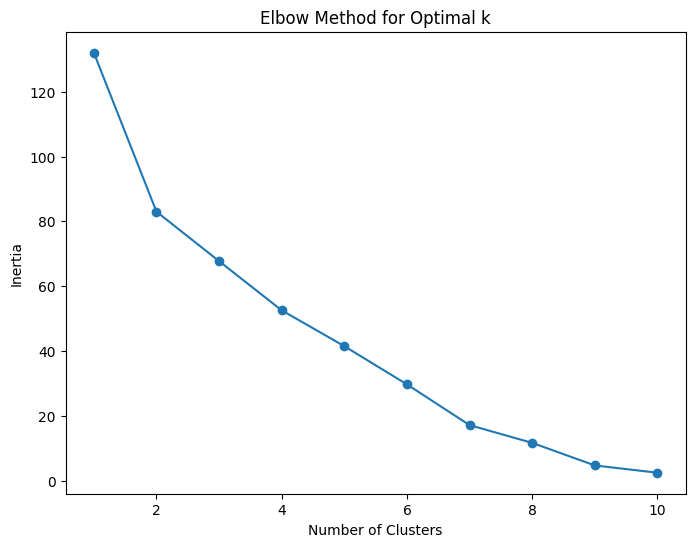

In [29]:
# Elbow Method to find the optimal number of clusters for K-Means
inertia = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8,6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### KMeans Clustering with PCA

In [30]:
# K-Means Clustering (using the optimal number of clusters from Elbow Method)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Adding KMeans cluster labels to the dataframe
monthly_mean_numeric['KMeans_Cluster'] = kmeans_labels

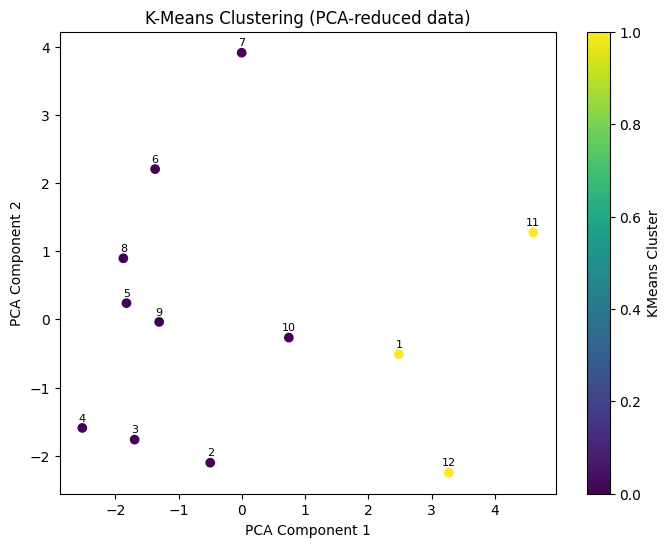

In [31]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=monthly_mean_numeric['KMeans_Cluster'], cmap='viridis', label='K-Means Clusters')

# Annotating each point with the corresponding month number
for i in range(len(pca_features)):
    plt.annotate(monthly_mean_numeric['month'][i], 
                 (pca_features[i, 0], pca_features[i, 1]), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', fontsize=8, color='black')

plt.title('K-Means Clustering (PCA-reduced data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='KMeans Cluster')
plt.show()


### K-distance graph to find optimal eps

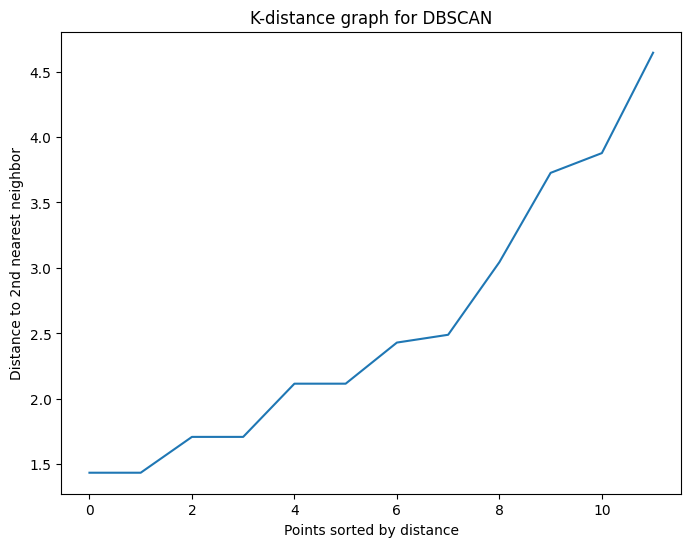

In [32]:
# DBSCAN Clustering (DBSCAN has two important parameters: eps and min_samples)
# Use Nearest Neighbors to find an optimal eps value
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances[:, 1], axis=0)

# Plotting k-distance graph to find the optimal eps value
plt.figure(figsize=(8,6))
plt.plot(distances)
plt.title('K-distance graph for DBSCAN')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 2nd nearest neighbor')
plt.show()

### DBSCAN Clustering with PCA

In [37]:
eps_value = 2.6
dbscan = DBSCAN(eps=eps_value, min_samples=2)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Adding DBSCAN cluster labels to the dataframe
monthly_mean_numeric['DBSCAN_Cluster'] = dbscan_labels

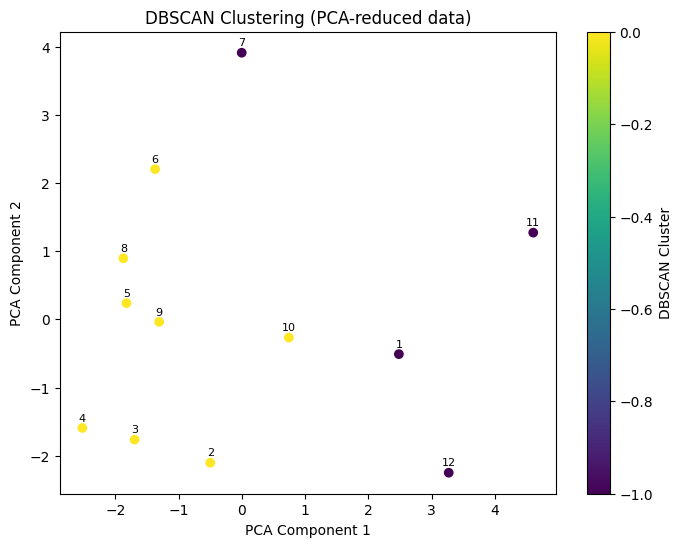

In [38]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=monthly_mean_numeric['DBSCAN_Cluster'], cmap='viridis', label='DBSCAN Clusters')

# Annotating each point with the corresponding month number
for i in range(len(pca_features)):
    plt.annotate(monthly_mean_numeric['month'][i], 
                 (pca_features[i, 0], pca_features[i, 1]), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', fontsize=8, color='black')

plt.title('DBSCAN Clustering (PCA-reduced data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='DBSCAN Cluster')
plt.show()


## **Forecasting using LSTM**

### Preprocessing for LSTM

In [40]:
def preprocess_data(df):
    # Encode month as cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Select features and target
    features = [
        'month_sin', 'month_cos', 'year',
        'Black carbon aerosol optical depth at 550 nm',
        'Dust aerosol optical depth at 550 nm',
        'Leaf area index low vegetation',
        'Organic matter aerosol optical depth at 550 nm',
        'Particulate matter d < 2.5 µm (PM2.5)',
        'Particulate matter d < 10 µm (PM10)',
        'Soil temperature level 1',
        'Surface pressure'
    ]
    target = 'Total aerosol optical depth at 550 nm'
    
    # Handle missing values (uncomment if needed)
    # df[features + [target]] = df[features + [target]].interpolate(method='linear')
    
    # Scale features and target
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features + [target]])
    
    # Save scaler for inverse transform
    target_scaler = MinMaxScaler()
    target_scaler.fit(df[[target]])
    
    return scaled_data, features, target, scaler, target_scaler

### Create Sequences

In [41]:
# Step 3: Create Sequences
def create_sequences(data, n_steps, target_col_idx):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])  # Sequence of n_steps
        y.append(data[i + n_steps, target_col_idx])  # Next value of target
    return np.array(X), np.array(y)


### Build and Train LSTM Model

In [42]:
# Step 4: Build and Train LSTM Model
def build_lstm_model(n_steps, n_features):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### Train the Model

In [47]:
df = pd.read_csv('dataset.csv')
df['valid_time'] = pd.to_datetime(df['valid_time'])
df['year'] = df['valid_time'].dt.year
df['month'] = df['valid_time'].dt.month

df.head()

,valid_time,latitude,longitude,Black carbon aerosol optical depth at 550 nm,Dust aerosol optical depth at 550 nm,Leaf area index low vegetation,Organic matter aerosol optical depth at 550 nm,Particulate matter d < 2.5 µm (PM2.5),Particulate matter d < 10 µm (PM10),Soil temperature level 1,Surface pressure,Total aerosol optical depth at 550 nm,population,year,month
0,2016-01-01 12:00:00,31.469,74.284,0.029164,0.016248,1.205675,0.534856,1.920000e-07,2.710000e-07,0.224423,99247.69,0.808605,1200.826152,2016,1
1,2016-01-02 12:00:00,31.469,74.284,0.025181,0.026584,1.644811,0.355844,1.150000e-07,1.620000e-07,0.142912,99131.75,0.553915,1200.826152,2016,1
2,2016-01-03 12:00:00,31.469,74.284,0.020344,0.068492,1.587820,0.329578,8.720000e-08,1.230000e-07,0.166913,98792.31,0.588048,1200.826152,2016,1
3,2016-01-04 12:00:00,31.469,74.284,0.017440,0.079398,1.089281,0.219141,4.670000e-08,6.570000e-08,0.105059,98195.06,0.422888,1200.826152,2016,1
4,2016-01-05 12:00:00,31.469,74.284,0.027403,0.203788,0.871900,0.318505,6.430000e-08,9.210000e-08,0.177101,97641.00,0.728252,1200.826152,2016,1


In [48]:
# Preprocess data
scaled_data, features, target, scaler, target_scaler = preprocess_data(df)
n_steps = 3
target_col_idx = len(features)  # Index of target in scaled_data

# Create sequences
X, y = create_sequences(scaled_data, n_steps, target_col_idx)

In [49]:
# Train-test split (75% train, 25% test)
train_size = int(len(X) * 0.75)  # 2016-2021 for training, 2022-2023 for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [50]:
# Build and train model
model = build_lstm_model(n_steps, len(features) + 1)  # +1 for target in input
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
					callbacks=[early_stopping], verbose=1)

Epoch 1/100


c:\Users\ABUBAKAR\anaconda3\envs\fyp\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step - loss: 0.1494 - val_loss: 0.1375
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1512 - val_loss: 0.1250
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1193 - val_loss: 0.1130
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1103 - val_loss: 0.1013
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1090 - val_loss: 0.0897
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0986 - val_loss: 0.0782
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0843 - val_loss: 0.0669
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0789 - val_loss: 0.0563
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0748 - val_loss: 0.0468
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0639 - val_loss: 0.0394
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0575 - val_loss: 0.0351
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0607 - val_loss

### Evaluate Model

In [51]:
# Evaluate model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss}")

Test MSE: 0.04691182076931


### Predict Future (January 2024)

In [52]:
# Predict January 2024
last_sequence = scaled_data[-n_steps:]  # Last 3 months (Oct-Dec 2023)
last_sequence = last_sequence.reshape((1, n_steps, last_sequence.shape[1]))
predicted_scaled = model.predict(last_sequence, verbose=0)
predicted_aod = target_scaler.inverse_transform(predicted_scaled)[0][0]
print(f"Predicted Total AOD for January 2024: {predicted_aod:.6f}")

Predicted Total AOD for January 2024: 0.626016


### Visualization

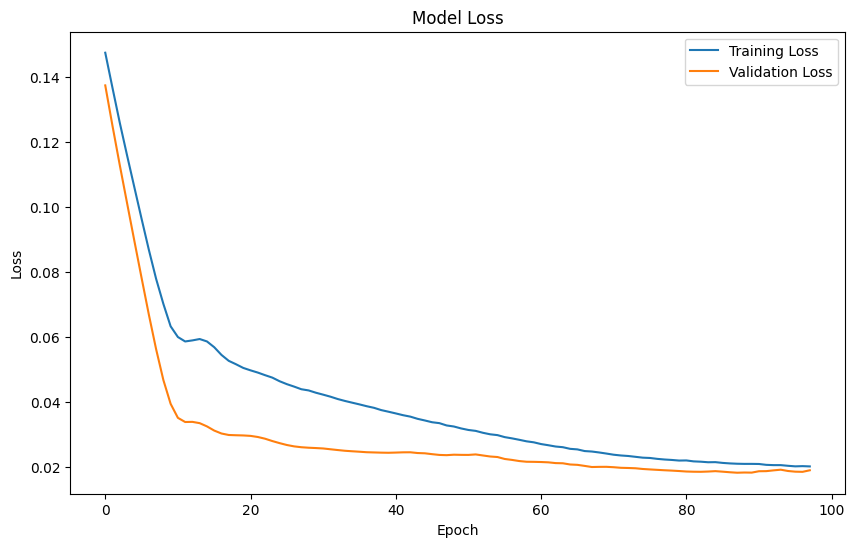

In [54]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# Plot actual vs predicted for test set
y_pred = model.predict(X_test, verbose=0)
y_pred = target_scaler.inverse_transform(y_pred)
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))

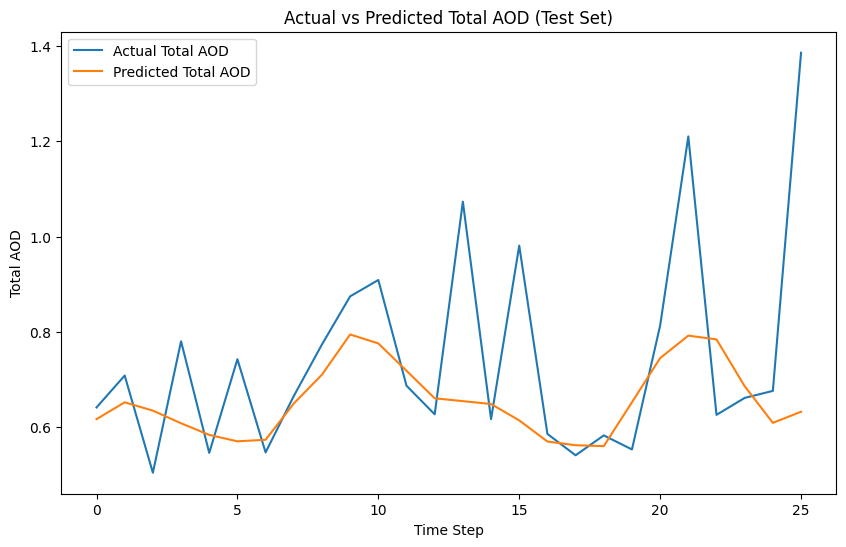

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, label='Actual Total AOD')
plt.plot(y_pred, label='Predicted Total AOD')
plt.title('Actual vs Predicted Total AOD (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Total AOD')
plt.legend()
plt.show()